### Forgery exposure CNN model - without use of Transfer Learning

In [0]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install numpy==1.16.1
# This version of numpy is needed for loading the np file which holds the pictures of signatures that will be used for modelling

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rn

import pathlib

from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import losses
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection

import os
import sys
import time

%matplotlib inline

import cv2

from google.colab.patches import cv2_imshow

import h5py

from keras import backend as K
import tensorflow as tf

In [0]:
# Setting up some random seeds
np.random.seed(7)
rn.seed(12345)
tf.set_random_seed(1234)

In [0]:
csv_fajl_1 = pd.read_csv("./drive/My Drive/signature-data/all signatures with flags preimenovani.csv")
y = csv_fajl_1["flag_if_forge"]
csv_fajl_1.head()

,signatures,flag_if_forge
0,014_forg/01_0102014.png,1
1,014_forg/02_0102014.png,1
2,014_forg/03_0102014.png,1
3,014_forg/04_0102014.png,1
4,004_forg/02_0103004.png,1


In [0]:
# Loading the np file that holds the pictures
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
nr_pictures = len(dataset_old)
nr_pictures

1649

In [0]:
HEIGHT = 244
WIDTH = 244

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
dataset_resized.shape

(1649, 244, 244, 3)

In [0]:
# Resizing the pictures to 244x244 
for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
dataset_resized = []

In [0]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.111, random_state=42, stratify=y_train)

In [0]:
# Preprocessing

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

In [0]:
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print()
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)
print()
print("X val shape: ", X_val.shape)
print("y val shape: ", y_val.shape)

X train shape:  (1319, 244, 244, 3)
y train shape:  (1319,)

X test shape:  (165, 244, 244, 3)
y test shape:  (165,)

X val shape:  (165, 244, 244, 3)
y val shape:  (165,)


In [0]:
# One hot encoding
def one_hot(y, C):
  y_one_hot = np.zeros((y.shape[0], C))
  y_one_hot[np.arange(0, y.shape[0]), y] = 1
    
  return y_one_hot

In [0]:
# Number of categories
C = 2

In [0]:
# Encoding the targets
y1_train = one_hot(y_train, C)
y1_test = one_hot(y_test, C)
y1_val = one_hot(y_val, C)

In [0]:
print("y train shape: ", y1_train.shape)
print()
print("y test shape: ", y1_test.shape)
print()
print("y val shape: ", y1_val.shape)

y train shape:  (1319, 2)

y test shape:  (165, 2)

y val shape:  (165, 2)


In [0]:
input_shape = X_train.shape[1:]
input_shape

(244, 244, 3)

In [0]:
# Final model architecure

x_input = Input(input_shape)

x = ZeroPadding2D(padding = (1,1))(x_input)
x = Conv2D(64, kernel_size = (5,5), strides = (1,1))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation("relu")(x)

x = AveragePooling2D(pool_size = (2,2))(x)

x = ZeroPadding2D(padding = (1,1))(x)
x = Conv2D(128, kernel_size = (5,5), strides = (1,1))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation("relu")(x)

x = AveragePooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
preds = Dense(C, activation="softmax")(x)

model = Model(inputs=x_input, outputs=preds)

In [0]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 242, 242, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 242, 242, 64)      256       
_________________________________________________________________
activation_21 (Activation)   (None, 242, 242, 64)      0         
_________________________________________________________________
average_pooling2d_20 (Averag (None, 121, 121, 64)      0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 123, 123, 64)      0   

In [0]:
model.compile(optimizer=SGD(lr=0.0001, nesterov=True), loss="binary_crossentropy", metrics=["acc"])

In [0]:
# Trained on 20 epochs and then for 10 more, because of the increaing trend of accuracy on the validation and train set
epochs = 10
batch_size = 32
verbose = 1
model_num = "51-proba"

In [0]:
checkpoints_path = './drive/My Drive/checkpoints/sign/'+'checkpoint-'+model_num+'-epoch-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoints_path1 = './drive/My Drive/checkpoints/sign/'+'checkpoint-'+model_num+'-history.txt'

callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto'),
            ModelCheckpoint(filepath=checkpoints_path,
                           verbose = verbose)]

t=time.time()

In [0]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    callbacks=callbacks,
                    validation_data = (X_val,y1_val)
                    )
    
print('Training time: %s' % (time.time()-t))

Train on 1319 samples, validate on 165 samples
Epoch 1/10
1319/1319 [==============================] - 481s 364ms/step - loss: 1.6261 - acc: 0.9985 - val_loss: 1.9827 - val_acc: 0.7939

Epoch 00001: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-515-proba-epoch-01-0.79.hdf5
Epoch 2/10
1319/1319 [==============================] - 480s 364ms/step - loss: 1.6207 - acc: 0.9985 - val_loss: 1.9471 - val_acc: 0.8121

Epoch 00002: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-515-proba-epoch-02-0.81.hdf5
Epoch 3/10
1319/1319 [==============================] - 481s 365ms/step - loss: 1.6160 - acc: 0.9992 - val_loss: 1.9554 - val_acc: 0.8242

Epoch 00003: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-515-proba-epoch-03-0.82.hdf5
Epoch 4/10
1319/1319 [==============================] - 481s 365ms/step - loss: 1.6131 - acc: 0.9977 - val_loss: 1.9496 - val_acc: 0.8303

Epoch 00004: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-515-proba-epoc

In [0]:
# Saving the model history on Google Drive
#f = open(checkpoints_path1,"w")
#f.write( str(history.history) )
#f.close()

In [0]:
# history1 was previously saved result from the first 20 epochs
history1 = {'val_loss': [2.193184774572199, 2.171663830497048, 2.1383287661003343, 2.10264309536327, 2.080371131318988, 2.0678513656963, 2.0961057980855307, 2.045445881467877, 2.1012506947372898, 2.0078263224977437, 2.186602903134895, 2.039865037166711, 1.979630489060373, 1.98625870328961, 1.9749946160749956, 2.0083213025873357, 1.9684594811815204, 1.957049010739182, 1.957107655207316, 1.9728954358534379], 'val_acc': [0.6060606062412262, 0.6606060613285412, 0.6787878795103593, 0.7151515158739957, 0.7272727279952078, 0.7393939401164199, 0.7030303033915433, 0.7393939401164199, 0.7151515155127555, 0.7818181825406624, 0.6666666670279069, 0.775757576118816, 0.8121212128436927, 0.7939393943006342, 0.8000000003612403, 0.775757576118816, 0.8242424246036645, 0.8121212128436927, 0.8060606067830866, 0.8303030306642706], 'loss': [2.2212942705812373, 2.097816994372781, 2.014158295536692, 1.9469721171781815, 1.898573438898915, 1.854457332836669, 1.819252326327621, 1.7878637617514657, 1.76630434039147, 1.7437329375445616, 1.7248945388041996, 1.7073306807792032, 1.6937223429748558, 1.6814149385875965, 1.668883700096038, 1.66094122599977, 1.6527193720544984, 1.644410357048694, 1.6389584602778207, 1.6329292952788428], 'acc': [0.5716451858823457, 0.7384382109012995, 0.81349507206945, 0.8703563305534496, 0.9006823351023503, 0.9211523882180475, 0.940864291174833, 0.9552691432903715, 0.9628506444727859, 0.9719484457922669, 0.978013646702047, 0.9825625474295714, 0.9878695981804397, 0.9916603487490523, 0.9924184988627748, 0.9931766489764974, 0.9946929492039424, 0.9939347990902199, 0.9977255496588324, 0.9969673995451099]}
# history2 is the model with 6 more epochs added afterwards
history2 = history.history

val_acc_hist1 = history1["val_acc"]
val_loss_hist1 = history1["val_loss"]
train_acc_hist1 = history1["acc"]
train_loss_hist1 = history1["loss"]

val_acc_hist2 = history2["val_acc"]
val_loss_hist2 = history2["val_loss"]
train_acc_hist2 = history2["acc"]
train_loss_hist2 = history2["loss"]

val_acc_hist1.extend(val_acc_hist2)
val_loss_hist1.extend(val_loss_hist2)
train_acc_hist1.extend(train_acc_hist2)
train_loss_hist1.extend(train_loss_hist2)

val_acc_hist = np.copy(val_acc_hist1)
val_loss_hist = np.copy(val_loss_hist1)
train_acc_hist = np.copy(train_acc_hist1)
train_loss_hist = np.copy(train_loss_hist1)

epochs = range(26)

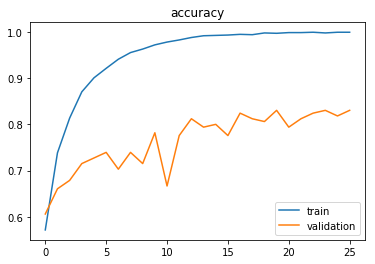

In [0]:
plt.title("accuracy")
plt.plot(epochs, train_acc_hist, label="train")
plt.plot(epochs, val_acc_hist, label = "validation")
plt.legend()

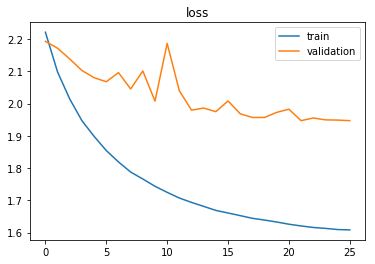

In [0]:
plt.title("loss")
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label = "validation")
plt.legend()

In [0]:
# From the graph, we can see that at epoch 13 validation loss becomes stationary, and accuracy too, so I chose to train the model on 13 epochs and use it as final model
val_acc_hist[12]

0.8121212128436927

In [0]:
# Training on train+val

x_input = Input(input_shape)

x = ZeroPadding2D(padding = (1,1))(x_input)
x = Conv2D(64, kernel_size = (5,5), strides = (1,1))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation("relu")(x)

x = AveragePooling2D(pool_size = (2,2))(x)

x = ZeroPadding2D(padding = (1,1))(x)
x = Conv2D(128, kernel_size = (5,5), strides = (1,1))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation("relu")(x)

x = AveragePooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x) # 
preds = Dense(C, activation="softmax")(x)

model = Model(inputs=x_input, outputs=preds)

model.compile(optimizer=SGD(lr=0.0001, nesterov=True), loss="binary_crossentropy", metrics=["acc"])

In [0]:
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
X_train = X_train/255
X_test = X_test/255
y1_train = one_hot(y_train,C)
y1_test = one_hot(y_test,C)

In [0]:
dataset_resized = []

In [0]:
epochs = 13
batch_size = 32
verbose = 1


checkpoints_path = './drive/My Drive/checkpoints/sign/'+'checkpoint-final-ntl-epoch-{epoch:02d}.hdf5'
checkpoints_path1 = './drive/My Drive/checkpoints/sign/'+'checkpoint-final-ntl-history.txt'

callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto'),
            ModelCheckpoint(filepath=checkpoints_path,
                           verbose = verbose)]

t=time.time()

In [0]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    callbacks=callbacks
                    )
    
print('Training time: %s' % (time.time()-t))

Epoch 1/13
1484/1484 [==============================] - 445s 300ms/step - loss: 2.2323 - acc: 0.5694

Epoch 00001: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-01.hdf5
Epoch 2/13
1484/1484 [==============================] - 441s 297ms/step - loss: 2.0956 - acc: 0.7257

Epoch 00002: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-02.hdf5
Epoch 3/13
1484/1484 [==============================] - 441s 297ms/step - loss: 2.0078 - acc: 0.8127

Epoch 00003: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-03.hdf5
Epoch 4/13
1484/1484 [==============================] - 443s 298ms/step - loss: 1.9367 - acc: 0.8652

Epoch 00004: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-04.hdf5
Epoch 5/13
1484/1484 [==============================] - 445s 300ms/step - loss: 1.8876 - acc: 0.8962

Epoch 00005: saving model to ./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-05.hdf5


In [0]:
#model = load_model("./drive/My Drive/checkpoints/sign/checkpoint-final-ntl-epoch-13.hdf5")

In [0]:
# genuine = positive -> 0
# forged = negative -> 1

# False Acceptance Rate
def FAR_acc(y, y_pred):
  FN = sum((y == 0) & (y_pred == 1))
  TP = sum((y == 0) & (y_pred == 0))
  return(FN / (FN + TP))


# False Rejection Rate
def FRR_acc(y, y_pred):
  FP = sum((y == 1) & (y_pred == 0))
  TN =  sum((y == 1) & (y_pred == 1))
  return(FP / (FP + TN))


# Both values should be as lower as possible, but with accent on FAR

In [0]:
def one_hot_decode(matrix):
  return np.array([list(row).index(1) for row in matrix])

In [0]:
def preds_decode(matrix):
  result = []
  for row in matrix:
    if row[0]>0.5:
      result.append(0)
    else: result.append(1)
  return np.array(result)

In [0]:
# TEST SET
test_loss, test_acc = model.evaluate(X_test, y1_test)

y_pred_test = model.predict(X_test)
y_pred_test_1 = preds_decode(y_pred_test)

test_FAR = FAR_acc(y_test, y_pred_test_1)
test_FRR = FRR_acc(y_test, y_pred_test_1)

165/165 [==============================] - 15s 93ms/step


In [0]:
print("Test Accuracy", test_acc)
print("Test FAR", test_FAR)
print("Test FRR", test_FRR)

Test Accuracy 0.775757576118816
Test FAR 0.30337078651685395
Test FRR 0.13157894736842105


In [0]:
# Final results.